In [1]:
import time
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from plot_keras_history import show_history, plot_history
from tqdm import tqdm

e:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\maben\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\maben\AppData\Roaming\Python

---

### **Emotions Labels :**
- 0 : Tristesse
- 1 : Joie 
- 2 : Amour
- 3 : Colère 
- 4 : Peur
- 5 : Surprise

In [ ]:
#charger le dataset
df = pd.read_csv('text1.csv')

In [38]:
df.head(5)

,text,label
0,C'est un plaisir de vous voir aujourd'hui !,1
1,Quelle magnifique journée pleine de bonheur !,1
2,Je me sens si bien en votre compagnie !,1
3,Ce moment me remplit de joie et de gratitude.,1
4,J'ai l'impression de flotter de bonheur !,1


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5325 entries, 0 to 5324
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5325 non-null   object
 1   label   5325 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 83.3+ KB


In [41]:
df.isna().count()

text     5325
label    5325
dtype: int64

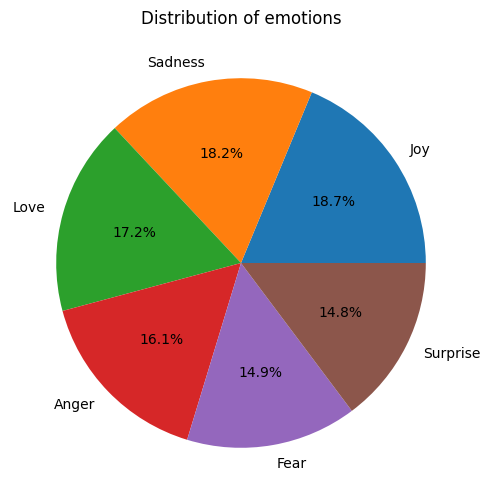

In [ ]:
emotion_dict = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}

# Replacing numbers with emotion names in labels
labels = df['label'].replace(emotion_dict)

# Creating a pie chart to see the distribution of emotions in the dataset
plt.figure(figsize=(8,6))
plt.pie(labels.value_counts(), labels=labels.unique(), autopct='%1.1f%%')
plt.title('Distribution of emotions')
plt.show()

---

In [8]:
from transformers import MarianMTModel, MarianTokenizer

In [43]:
print(df['label'].value_counts())


label
5    998
2    971
3    916
4    858
0    796
1    786
Name: count, dtype: int64


In [63]:
print("Colonnes dans train_df :", train_df.columns)
print("Colonnes dans validation_df :", validation_df.columns)
print("Colonnes dans test_df :", test_df.columns)


Colonnes dans train_df : Index(['text1', 'label'], dtype='object')
Colonnes dans validation_df : Index(['text1', 'label'], dtype='object')
Colonnes dans test_df : Index(['text1', 'label'], dtype='object')


In [64]:
import pandas as pd

# Charger les fichiers CSV existants
train_df = pd.read_csv('fr_train.csv')
validation_df = pd.read_csv('fr_validation.csv')
test_df = pd.read_csv('fr_test.csv')

# Vérifier les tailles des ensembles de données
print("Taille des ensembles :")
print(f"Entraînement : {train_df.shape[0]} exemples")
print(f"Validation : {validation_df.shape[0]} exemples")
print(f"Test : {test_df.shape[0]} exemples")

# Vérifier la distribution des classes dans chaque ensemble
print("\nDistribution des classes :")
print("Entraînement :")
print(train_df['label'].value_counts())

print("\nValidation :")
print(validation_df['label'].value_counts())

print("\nTest :")
print(test_df['label'].value_counts())

# Préparer les données pour le modèle
train_texts, train_labels = train_df['text1'], train_df['label']
validation_texts, validation_labels = validation_df['text1'], validation_df['label']
test_texts, test_labels = test_df['text1'], test_df['label']




Taille des ensembles :
Entraînement : 3000 exemples
Validation : 600 exemples
Test : 600 exemples

Distribution des classes :
Entraînement :
label
4    500
0    500
2    500
1    500
5    500
3    500
Name: count, dtype: int64

Validation :
label
4    100
0    100
2    100
1    100
5    100
3    100
Name: count, dtype: int64

Test :
label
4    100
0    100
2    100
1    100
5    100
3    100
Name: count, dtype: int64


---

## **DistilBert**

In [ ]:
distil_bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distil_bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6) # 6 classes de emotions

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distil_bert_model = distil_bert_model.to(device)

In [67]:
train_encodings = distil_bert_tokenizer(train_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
train_labels = torch.tensor(train_labels.tolist())
train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, train_labels)

In [ ]:
validation_encodings = distil_bert_tokenizer(validation_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
validation_labels = torch.tensor(validation_labels.tolist())
validation_dataset = TensorDataset(validation_encodings.input_ids, validation_encodings.attention_mask, validation_labels)

In [ ]:
test_encodings = distil_bert_tokenizer(test_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
test_labels = torch.tensor(test_labels.tolist())
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, test_labels)

In [ ]:
lr = 5e-5
optimizer = torch.optim.Adam(distil_bert_model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()
metrics = ['accuracy']

# Model compilation
epochs = 15
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
history = {
    'train_loss': [],
    'validation_loss': [],
    'validation_accuracy': []
}
best_acc = 0.0

l2_lambda = 0.001

start_time = time.time()
for epoch in range(epochs):
    # Training
    distil_bert_model.train()
    total_loss = 0
    train_loader_progress = tqdm(train_loader, desc='Training')
    for batch in train_loader_progress:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = distil_bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        l2_norm = sum(p.pow(2.0).sum() for p in distil_bert_model.parameters())
        loss = loss + l2_lambda * l2_norm

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_loader_progress.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    avg_train_loss = total_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    distil_bert_model.eval()
    total_val_loss = 0
    total_correct = 0
    total_samples = 0
    validation_loader_progress = tqdm(validation_loader, desc='Validating')
    for batch in validation_loader_progress:
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = distil_bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_val_loss += loss.item()

        _, predictions = torch.max(outputs.logits, dim=1)
        correct = (predictions == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

    avg_val_loss = total_val_loss / len(validation_loader)
    val_accuracy = total_correct / total_samples
    history['validation_loss'].append(avg_val_loss)
    history['validation_accuracy'].append(val_accuracy)

    print(f"Epoch: {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_acc:
        best_acc = val_accuracy
        if not os.path.exists('Poids'):
            os.makedirs('Poids')
        torch.save(distil_bert_model.state_dict(), 'Poids/fr_best_distilbert.pth')

end_time = time.time()

Validating: 100%|██████████| 19/19 [00:02<00:00,  8.66it/s]


Epoch: 1, Training Loss: 164.6793, Validation Loss: 1.7905, Validation Accuracy: 0.1683


Validating: 100%|██████████| 19/19 [00:02<00:00,  8.59it/s]


Epoch: 2, Training Loss: 144.6798, Validation Loss: 1.7776, Validation Accuracy: 0.1983


Validating: 100%|██████████| 19/19 [00:02<00:00,  8.70it/s]


Epoch: 3, Training Loss: 127.5588, Validation Loss: 1.2885, Validation Accuracy: 0.5117


Validating: 100%|██████████| 19/19 [00:02<00:00,  9.15it/s]


Epoch: 4, Training Loss: 113.9039, Validation Loss: 1.0127, Validation Accuracy: 0.6567


Validating: 100%|██████████| 19/19 [00:02<00:00,  9.17it/s]


Epoch: 5, Training Loss: 102.9336, Validation Loss: 1.0079, Validation Accuracy: 0.6717


Validating: 100%|██████████| 19/19 [00:02<00:00,  9.14it/s]


Epoch: 6, Training Loss: 93.6559, Validation Loss: 0.8755, Validation Accuracy: 0.7150


Validating: 100%|██████████| 19/19 [00:02<00:00,  9.16it/s]


Epoch: 7, Training Loss: 85.5819, Validation Loss: 0.9224, Validation Accuracy: 0.7133


Validating: 100%|██████████| 19/19 [00:02<00:00,  9.16it/s]


Epoch: 8, Training Loss: 78.4671, Validation Loss: 1.1253, Validation Accuracy: 0.6883


Validating: 100%|██████████| 19/19 [00:02<00:00,  9.14it/s]


Epoch: 9, Training Loss: 72.1384, Validation Loss: 1.0565, Validation Accuracy: 0.7250


Validating: 100%|██████████| 19/19 [00:02<00:00,  9.14it/s]


Epoch: 10, Training Loss: 66.4953, Validation Loss: 1.1850, Validation Accuracy: 0.7017


Validating: 100%|██████████| 19/19 [00:02<00:00,  8.69it/s]


Epoch: 11, Training Loss: 61.4121, Validation Loss: 1.1759, Validation Accuracy: 0.7167


Validating: 100%|██████████| 19/19 [00:02<00:00,  9.17it/s]


Epoch: 12, Training Loss: 56.8672, Validation Loss: 1.2448, Validation Accuracy: 0.7200


Validating: 100%|██████████| 19/19 [00:02<00:00,  8.73it/s]


Epoch: 13, Training Loss: 52.7615, Validation Loss: 1.3985, Validation Accuracy: 0.6817


Validating: 100%|██████████| 19/19 [00:02<00:00,  8.74it/s]


Epoch: 14, Training Loss: 49.0534, Validation Loss: 1.3640, Validation Accuracy: 0.7000


Validating: 100%|██████████| 19/19 [00:02<00:00,  8.64it/s]

Epoch: 15, Training Loss: 45.6845, Validation Loss: 1.4191, Validation Accuracy: 0.7033


In [72]:
time_train_distilbert = end_time - start_time
print(f"Training Time --> {time_train_distilbert/60}")

Training Time --> 64.23944443861643


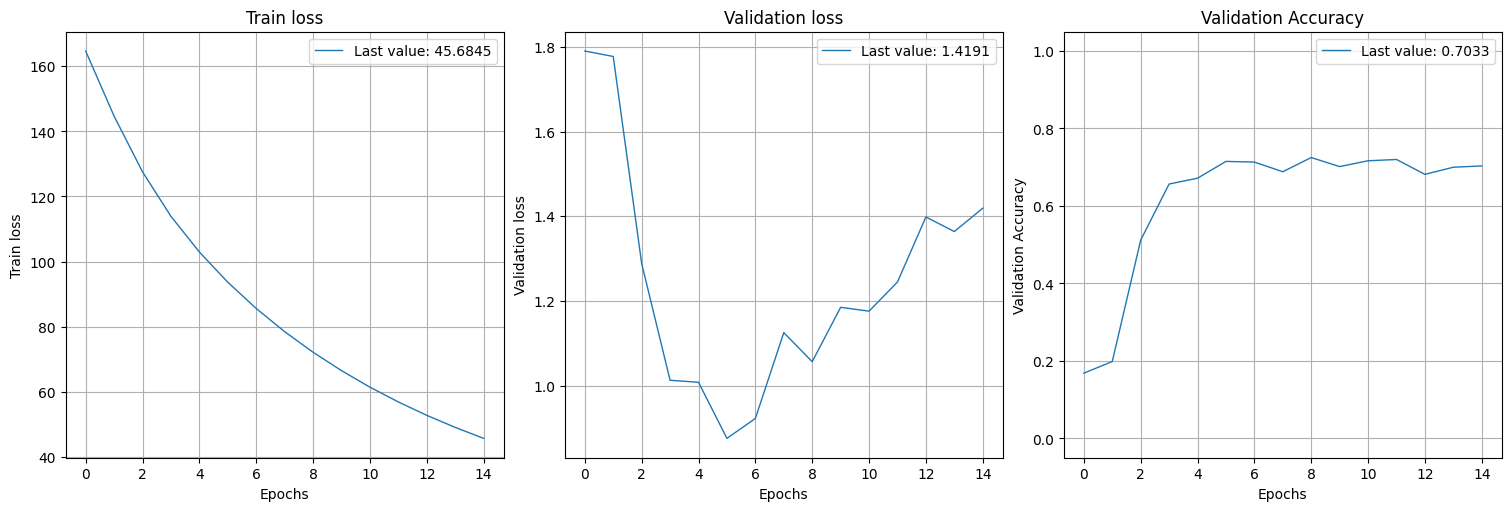

In [76]:
show_history(history)
plt.close()